# Bank Account Fraud Detection

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Read Data**

In [4]:
# import data
data = pd.read_csv('../data/raw/raw_data.csv')
print(f"data shape: {data.shape}")
data.head()

data shape: (1000000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


## Data Cleaning

1. Split into numerical and categorical columns
2. Check number of missing values

In [9]:
# define categorical and numerical columns
categorical_columns = ['fraud_bool', 'payment_type', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'source', 'device_os']

# define numerical columns, everything else
numerical_columns = [col for col in data.columns if col not in categorical_columns]

In [11]:
# change datatype of categorical columns to 'category'
data[categorical_columns] = data[categorical_columns].astype('category')

In [12]:
# print columnn names
data.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [18]:
# columns with potential missing values
na_cols = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

# check for missing values, if values are -1 or negative, they are considered missing
missing = data[na_cols].replace(-1, np.nan).isnull().sum().to_frame().reset_index()
missing.columns = ['columns', 'na_count']
missing['na_percentage'] = round(missing['na_count'] / data.shape[0] * 100, 2)
missing

,columns,na_count,na_percentage
0,prev_address_months_count,712920,71.29
1,current_address_months_count,4254,0.43
2,intended_balcon_amount,0,0.00
3,bank_months_count,253635,25.36
4,session_length_in_minutes,2015,0.20
5,device_distinct_emails_8w,359,0.04


## EDA Bank Activity and Device Activity

* Device Activity:
    * `session_length_in_minutes`
    * `device_os`
    * `keep_alive_session`
    * `device_distinct_emails_8w`
    * `device_fraud_count` (can drop this column)
    * `source`
    * `foreign_request`

* Bank Activity:
    * `zip_count_4w`
    * `velocity_6h`
    * `velocity_24h`
    * `velocity_4w`
    * `bank_branch_count_8w`
    * `date_of_birth_distinct_emails_4w`


In [24]:
# select columns related to device activity
device_activity  = ['fraud_bool', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'source', 'foreign_request']
device_activity_df = data[device_activity]

# print shape
device_activity_df.shape

(1000000, 8)

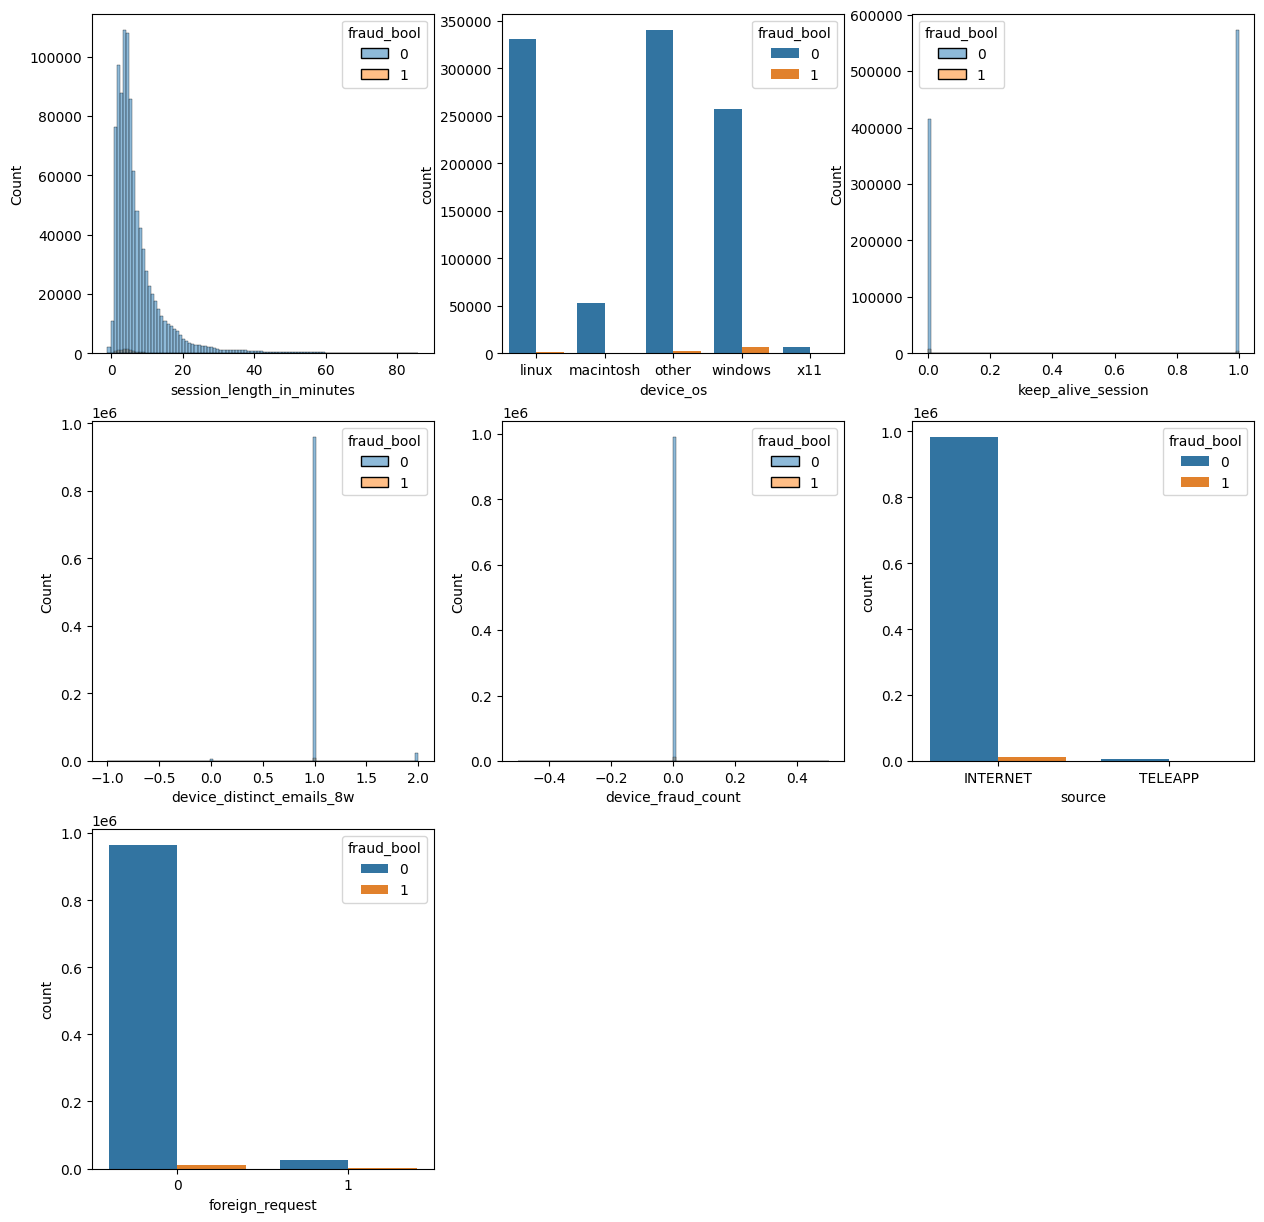

In [27]:
# for each column, if it is categorical, plot the value counts, if it is numerical, plot histogram
# put in a 3 x 3 grid, and color code the fraud_bool column
# print all except the first column
plt.figure(figsize=(15, 15))
for i, col in enumerate(device_activity_df.columns[1:]):
    plt.subplot(3, 3, i+1)
    if device_activity_df[col].dtype.name == 'category':
        sns.countplot(data=device_activity_df, x=col, hue='fraud_bool')
    else:
        sns.histplot(data=device_activity_df, x=col, hue='fraud_bool', bins=100)

In [45]:
# group by device_os, calculate proportion of fraud_bool == 1
def proportion_fraud(x):
    return (x == 1).sum() / x.shape[0]

device_os_fraud = device_activity_df.groupby('device_os')['fraud_bool'].apply(proportion_fraud).sort_values(ascending=False)
device_os_fraud

device_os
windows      0.024694
macintosh    0.013971
x11          0.011206
other        0.005760
linux        0.005155
Name: fraud_bool, dtype: float64

device_os
other        342728
linux        332712
windows      263506
macintosh     53826
x11            7228
Name: count, dtype: int64


<Axes: xlabel='device_os', ylabel='count'>

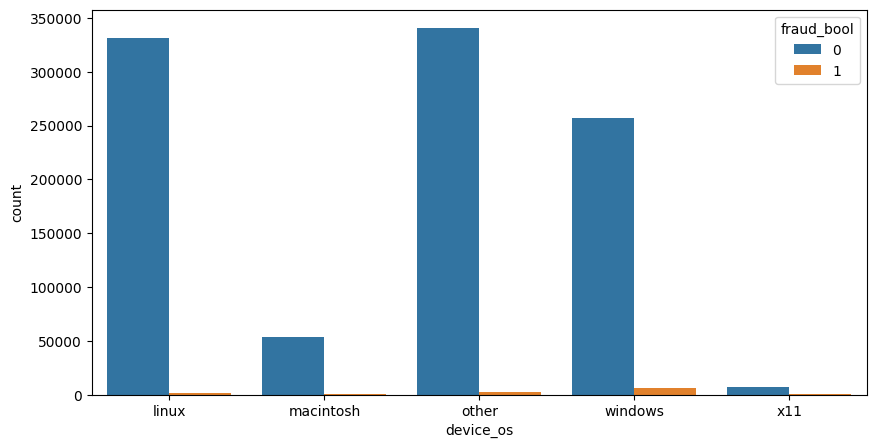

In [38]:
# check device_os value_counts
print(device_activity_df['device_os'].value_counts())

# plot device_os value counts, color coded by fraud_bool
plt.figure(figsize=(10, 5))
sns.countplot(data=device_activity_df, x='device_os', hue='fraud_bool')

keep_alive_session
1    576947
0    423053
Name: count, dtype: int64


<Axes: xlabel='keep_alive_session', ylabel='count'>

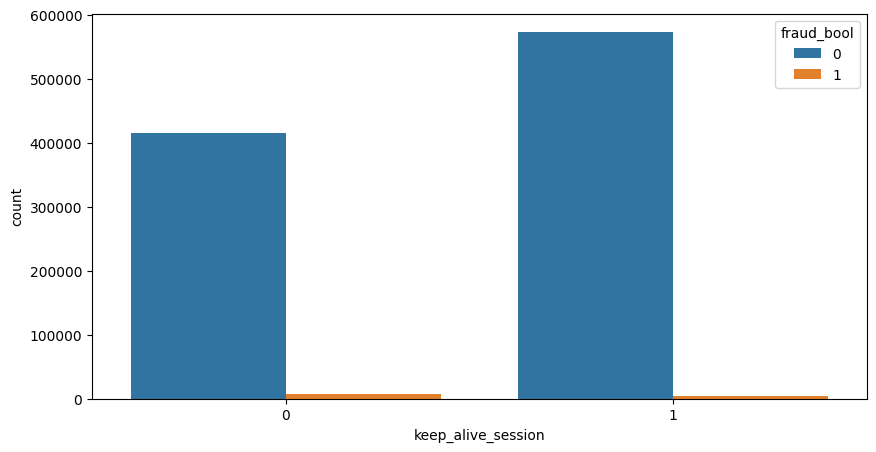

In [31]:
# check keep_alive_session value_counts
print(device_activity_df['keep_alive_session'].value_counts())

# plot keep_alive_session value counts, color coded by fraud_bool
plt.figure(figsize=(10, 5))
sns.countplot(data=device_activity_df, x='keep_alive_session', hue='fraud_bool')

device_distinct_emails_8w
 1    968067
 2     25302
 0      6272
-1       359
Name: count, dtype: int64


<Axes: xlabel='device_distinct_emails_8w', ylabel='count'>

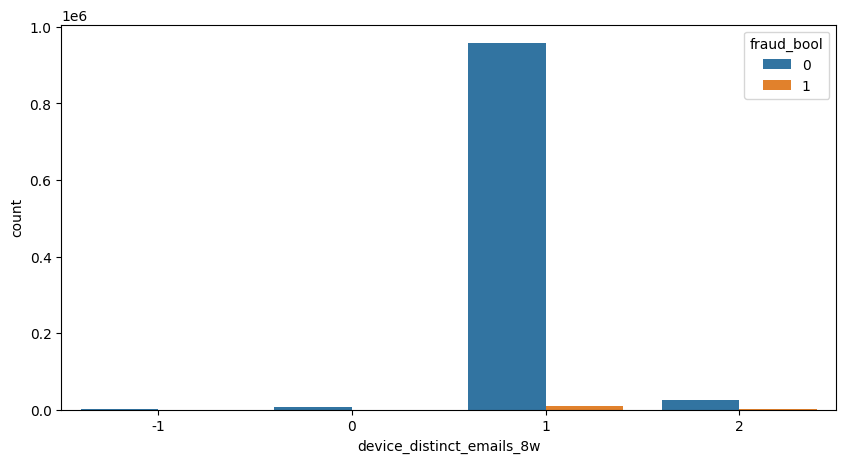

In [32]:
# device_distinct_emails_8w value_counts
print(device_activity_df['device_distinct_emails_8w'].value_counts())

# plot device_distinct_emails_8w value counts, color coded by fraud_bool
plt.figure(figsize=(10, 5))
sns.countplot(data=device_activity_df, x='device_distinct_emails_8w', hue='fraud_bool')

In [33]:
# check device_fraud_count value_counts
device_activity_df['device_fraud_count'].value_counts()

device_fraud_count
0    1000000
Name: count, dtype: int64

<Axes: xlabel='source', ylabel='count'>

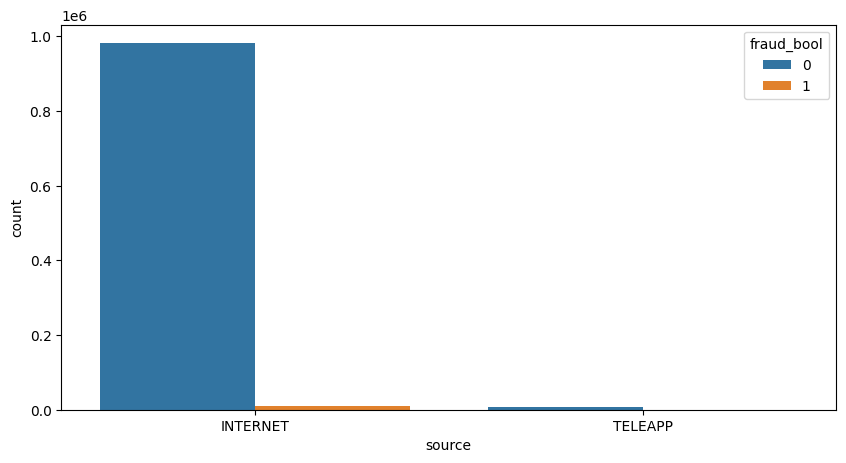

In [34]:
# check source value_counts
device_activity_df['source'].value_counts()

# plot source value counts, color coded by fraud_bool
plt.figure(figsize=(10, 5))
sns.countplot(data=device_activity_df, x='source', hue='fraud_bool')

<Axes: xlabel='foreign_request', ylabel='count'>

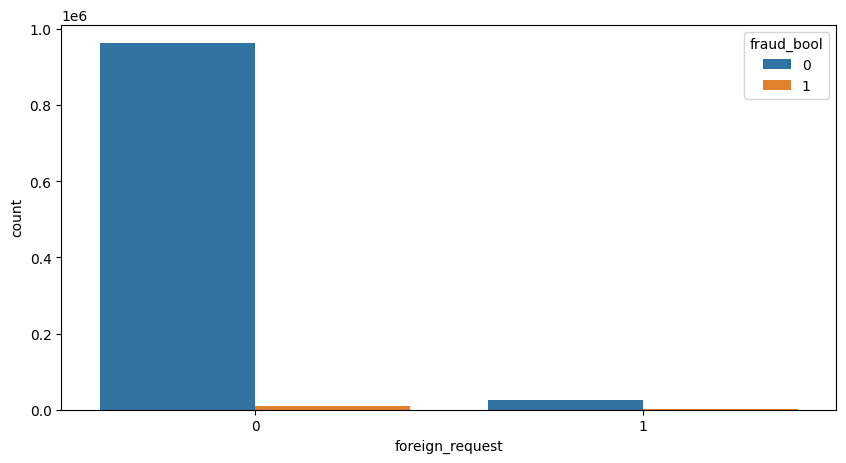

In [35]:
# check foreign_request value_counts
device_activity_df['foreign_request'].value_counts()

# plot foreign_request value counts, color coded by fraud_bool
plt.figure(figsize=(10, 5))
sns.countplot(data=device_activity_df, x='foreign_request', hue='fraud_bool')

In [36]:
# drop device_fraud_count
device_activity_df.drop('device_fraud_count', axis=1, inplace=True)

# print shape
print(f'device_activity_df shape: {device_activity_df.shape}')
device_activity_df.head()

device_activity_df shape: (1000000, 7)


/var/folders/_3/8z9s_23x6w349w1_9vlqlhzh0000gn/T/ipykernel_38705/1865295421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  device_activity_df.drop('device_fraud_count', axis=1, inplace=True)


,fraud_bool,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,source,foreign_request
0,0,16.224843,linux,1,1,INTERNET,0
1,0,3.363854,other,1,1,INTERNET,0
2,0,22.730559,windows,0,1,INTERNET,0
3,0,15.215816,linux,1,1,INTERNET,0
4,0,3.743048,other,0,1,INTERNET,0


<Axes: xlabel='session_length_in_minutes', ylabel='Count'>

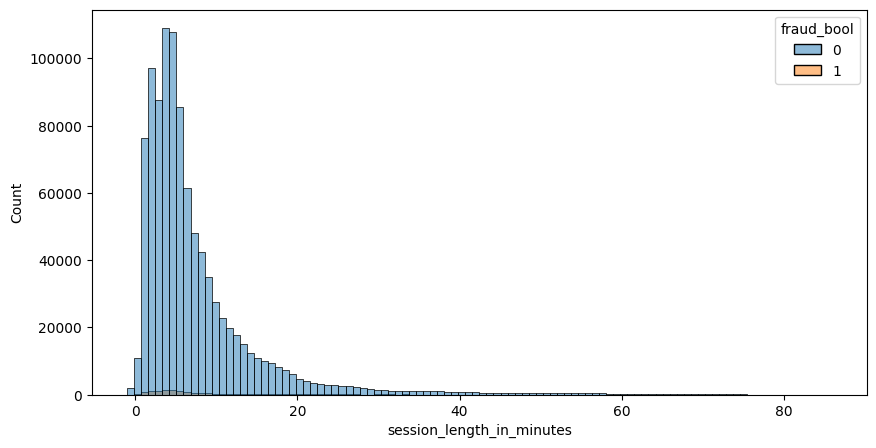

In [46]:
# investigate distribution of session_length_in_minutes for fraud and non-fraud
plt.figure(figsize=(10, 5))
sns.histplot(data=device_activity_df, x='session_length_in_minutes', hue='fraud_bool', bins=100)